<a href="https://colab.research.google.com/github/JehadOumer/IMDB-Reviews-Classification/blob/main/Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import seaborn as sns
import re
from wordcloud import WordCloud
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## fetching the dataset from tensorflow, splitting to training, testing and validation

In [2]:
(training_data, validation_data, testing_data), ds_info  = tfds.load(
    name="imdb_reviews", split=('train+test[0:5000]', 'test[5000:15000]', 'test[15000:]'), as_supervised=True, with_info=True)
##The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRAGC5J/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRAGC5J/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRAGC5J/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
##convert to pandas data frame
training_data = tfds.as_dataframe(training_data, ds_info)
validation_data= tfds.as_dataframe(validation_data, ds_info)
testing_data=tfds.as_dataframe(testing_data, ds_info)
all_data = pd.concat([training_data, testing_data, validation_data])


In [4]:
print("Dataset length: ", len(all_data["label"]), "points")
print("Training set length: ", len(training_data["label"]), "points")
print("Validation set length: ", len(validation_data["label"]), "points")
print("Testing set length: ", len(testing_data["label"]), "points")



Dataset length:  50000 points
Training set length:  30000 points
Validation set length:  10000 points
Testing set length:  10000 points


In [5]:
training_data.tail(5)

,label,text
29995,0,"b'I have a severe problem with this show, seve..."
29996,1,"b'The year is 1964. Ernesto ""Che"" Guevara, hav..."
29997,0,b'Okay. So I just got back. Before I start my ...
29998,0,b'When I saw this trailer on TV I was surprise...
29999,1,"b'First of all, Riget is wonderful. Good comed..."


In [6]:
validation_data.head(5)

,label,text
0,0,"b""I had always eyed Italian horror maestro Dar..."
1,0,"b""This is supposed to be based on Wilkie Colli..."
2,1,b'So I guess that Bud and Lou just liked to me...
3,1,b'I opted to watch this film for one reason an...
4,1,"b'Overall, a well done movie. There were the p..."


In [7]:
validation_data.tail(5)

,label,text
9995,1,"b""Christopher Nolan's first film is a 'no budg..."
9996,0,b'The commercials for RAT RACE made it look to...
9997,1,"b""If you take the movie for what it is worth, ..."
9998,1,"b""King of the Underworld features an early rol..."
9999,1,"b""Human Traffic is a view into an average week..."


In [8]:
testing_data.head(5)

,label,text
0,1,"b""I saw this play on Showtime some years back ..."
1,0,"b""Remnants of an ambushed Army unit hook up wi..."
2,0,b'I recently picked up all three Robocop films...
3,1,b'A great movie about triumph over all the nay...
4,1,b'The Lone Ranger was one of my childhood hero...


# Loading the processed version of the dataset, see **DataWrangling.ipynb**

In [2]:
training = pd.read_csv('/content/drive/MyDrive/IMDB Review Dataset Processed/processed_training_data.csv')
validation = pd.read_csv('/content/drive/MyDrive/IMDB Review Dataset Processed/processed_validation_data.csv')
testing = pd.read_csv('/content/drive/MyDrive/IMDB Review Dataset Processed/processed_testing_data.csv')


In [3]:
#full dataset = training+validation+testing

full_dataset = training.append(validation)
full_dataset = full_dataset.append(testing)

In [4]:
#splitting positive reviews and negative reviews
neg_reviews=full_dataset[full_dataset['label']==0]
pos_reviews=full_dataset[full_dataset['label']==1]


The number of positive reviews:  25000
The number of negative reviews:  25000


Text(0.5, 1.0, 'Class Distribution')

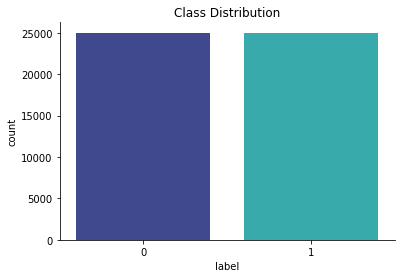

In [20]:
## Data distribution in terms of labels
print("The number of positive reviews: ", len(pos_reviews))
print("The number of negative reviews: ", len(neg_reviews))
sns.countplot(x='label', data = full_dataset, palette = 'mako',
              saturation = 1)
sns.despine()
plt.title('Class Distribution')

### Generate Frequency Matrix (BoW)

In [5]:
#
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
count_vectorizer.fit((full_dataset['text']))
vectorized = count_vectorizer.transform(full_dataset['text'])
print(dict(list(count_vectorizer.vocabulary_.items())[0:8]))
print('The transformed data matrix dimensions:', vectorized.shape)

{'absolutely': 12311, 'terrible': 1668092, 'movie': 1059072, 'lure': 975226, 'person': 1195276, 'great': 710902, 'actor': 26609, 'simply': 1515047}
The transformed data matrix dimensions: (50000, 1877726)


In [6]:
#make the sparse matrix dense and sort it
sum_words = vectorized.sum(axis=0)
count_sorted = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
count_sorted = sorted(count_sorted, key = lambda x: x[1], reverse=True)

In [14]:
count_sorted[0:50]

[('pron', 825010),
 ('person', 242164),
 ('movie', 102649),
 ('film', 94609),
 ('cardinal', 81615),
 ('org', 68090),
 ('pron pron', 67015),
 ('gpe', 45104),
 ('make', 45037),
 ('like', 44172),
 ('good', 40637),
 ('time', 37229),
 ('just', 35033),
 ('person person', 32624),
 ('date', 30927),
 ('work', 28840),
 ('character', 28287),
 ('watch', 27757),
 ('bad', 26214),
 ('person pron', 25238),
 ('story', 25068),
 ('think', 23255),
 ('really', 23089),
 ('movie pron', 21960),
 ('scene', 21395),
 ('ordinal', 20167),
 ('great', 19826),
 ('look', 19482),
 ('say', 19166),
 ('know', 18963),
 ('people', 18278),
 ('art', 18075),
 ('way', 17118),
 ('play', 16977),
 ('film pron', 16971),
 ('love', 16853),
 ('come', 16417),
 ('thing', 16386),
 ('pron think', 15399),
 ('work art', 15280),
 ('norp', 15076),
 ('end', 14893),
 ('man', 14826),
 ('life', 14626),
 ('plot', 13650),
 ('actor', 13512),
 ('make pron', 13221),
 ('want', 13144),
 ('pron just', 12606),
 ('try', 12484)]

### Finding terms with with highest TF-IDF scores

In [9]:
# Train a TF-IDF structure
# count words in a collection of documents (D)
# where structure D[doc][word]
# return word/document dictionary: 
#   T['///---///'][doc] = number_words_in_doc
#   T[word]['D'] = occurancs_word_in_collection
#   T[word]['d'][doc]['f'] = occurances_word_in_doc
#   T[word]['d'][doc]['tf'] = term frequency : T[word]['d'][doc]['f'] / T["///--///"][doc]


def TF_IDF(D, T={}):
    for d in D: # d: document
        for w in D[d]: # w: words in document
                
            # count frequency of term w in documnt d
            T.setdefault(w, {})
            T[w].setdefault('d', {})
            T[w]['d'].setdefault(d, {})
            T[w]['d'][d].setdefault('f', 0)
            
            # increment word count for document 
            T[w]['d'][d]['f'] += 1
                
            # increment frequency of w only once per document d
            T[w].setdefault('D', 0)
            if(T[w]['d'][d]['f'] == 1):  
                T[w]['D'] += 1
                                  
            
        # count terms in document d
        T.setdefault("///d///", {})
        T["///d///"].setdefault(d, 0)
        T["///d///"][d] += len(D[d])

    # number of documents     
    T["///d///"].setdefault("#docs", 0)
    T["///d///"]["#docs"] += len(D.keys())
    
    
    # set of word indexes
    T["///d///"].setdefault("#include", set())
    
    # indexes of words
    T["///d///"].setdefault("idx", {})
       
    # compute tf-idf
    idx = 0 # index of word 
    for w in T: # d: document
        # Ignore if not a word
        if(w == "///d///"): continue
        
        # unique index of word 
        T[w]['idx'] = idx
        T["///d///"]['#include'] = T["///d///"]['#include'].union({idx})
        T["///d///"]['idx'][idx] = w
        idx +=1 
        
        # number of documents   /  
        idf = np.log(T["///d///"]["#docs"]/T[w]['D'])
        T[w]['idf'] = idf
        
        # compute tfidf
        for d in T[w]['d']: # d: document
            tf = T[w]['d'][d]['f'] / T["///d///"][d]  
            T[w]['d'][d]['tf'] = tf
            T[w]['d'][d]['tfidf'] = tf * idf
            
    # number of documents     
    T["///d///"].setdefault("#words", 0)
    T["///d///"]["#words"] = len(T["///d///"]['#include'])

    return T
 
#############################


# create tokenized word Vectors from documents in a collection  
def TFIDFvector(D, T):
    
    W = {} # dictionary of word vectors with tfidf values 
    for d in D:
        
        V = T["///d///"]["#words"] * [0] # allocate word vector, instantiate with 0
        H = {} # count frequency of words (terms) in Document
        cnt = 0 # count number of indexed terms (w) in document d
        for w in D[d]:
            if(w in T): 
                idx = T[w]['idx']
                if (idx in T["///d///"]['#include']) : 
                    H.setdefault(w, 0)
                    H[w] += 1
                    cnt += 1
        for w in H:
            idx = T[w]['idx']
            tf = H[w] / cnt          
            V[idx] = tf * T[w]['idf']
        W[d] = V
    return W


# generate m labels for word vectore 
def labelVector(W, T, m=1, verbose = 0):
    
    L = []
    for d in W:
        V = W[d]
        
        # rank Vector by value 
        R = [index for element, index in sorted(zip(V, range(len(V))), reverse=True)]

        l = ''
        for i in range(len(R)):
            r = R[i]
            if(V[r] == 0) : break
            
            # number of important keywords
            if (i == m): break
            l = f"{l}-{T['///d///'][r]}" # get the indexed word
            if(verbose) : print(f"{d}  {i}\t{float(V[r]):4.4}\t{r}\t {T['///d///'][r]}")
        L.append(f"{d}-{l}")
    return L


# print TF-IDF 
def printTfIdf(w, T) :
    print(f"{w:<8}\t#d:{T[w]['D']}\tidf:{T[w]['idf']:4.4}\tVln:{len(T.keys())}")
    for d in T[w]['d'] :
        f = T[w]['d'][d]['f']
        tf = T[w]['d'][d]['tf']
        idf = T[w]['idf']
        tfidf = T[w]['d'][d]['tfidf']

        print(f"{d:<8}\tcnt:{f}\ttf:{tf:4.4}\ttfidf:{tfidf:4.4}")              
        
                                 
#####################################################################
# create tokenized word Vectors from documents in a collection  
def bestTFIDF(D, T, n=3):
    W = set() # dictionary of word vectors with tfidf values 
    for d in D:
        V = {(i+1)*-1:"" for i in range(n)}
                  
        H = {} # count frequency of words (terms) in Document
        cnt = 0 # count number of indexed terms (w) in document d
        for w in D[d]:
            if(w in T): 
                idx = T[w]['idx']
                if (idx in T["///d///"]['#include']) : 
                    H.setdefault(w, 0)
                    H[w] += 1
                    cnt += 1
        for w in H:
            idx = T[w]['idx']
            tf = H[w] / cnt
            tfidf = tf * T[w]['idf']
            for i in sorted(V):
                if(tfidf > i): 
                    del V[i]
                    V[tfidf] = w
                    break 
        #print("d", d, V)
        for tfidf in V: W = W.union({V[tfidf]})
    return W

          
          
# create a list of joint n-highest ranking tf-idf values per document 
def nBestValues(W, T, n=10):
    
    idx = set() # set of highest tf-idf words
    for d in W:
        # rank Vector by value 
        V = W[d]
        R = [index for element, index in sorted(zip(V, range(len(V))), reverse=True)]
        
        for i in range(len(R)):
            r = R[i]
            if(V[r] == 0) : break # stop if index 
            if(i == n) : break # stop it index 
            idx = idx.union({T['///d///']['idx'][r]})   
    
    return idx

# create word Vectors from (the first) n documents in a collection  
def nBestIndex(T, nBest):
    
    idx = 0
    T["///d///"]['#include'] = set()
    T["///d///"]["#words"] = len(nBest)
    for w in nBest:
        T[w]['idx'] = idx
        T["///d///"]['#include'] = T["///d///"]['#include'].union({idx})
        idx += 1



## Read From Documents (Modified to fit pandas dataframe)

In [26]:
def readDocumentCollection(df) :
    D = {}
    i = 0

    # sort documents to retrieve th first n documents
    for index, row in df.iterrows():
        # read n documents
  
        i += 1
        D.setdefault(i, [])
        
        # process document as a flat list of tokens
        D[i].extend(row['text'].split(" "))

    return D

In [27]:
#create a tokenized dictionary of words for whole dataset
dataset_tokenized=readDocumentCollection(full_dataset)

## Create TF-IDF Data Strucutre and build the model

In [30]:
T = TF_IDF(dataset_tokenized, T={})
T = TF_IDF(dataset_tokenized, T=T)

In [39]:
#get best n terms based on TFIDF score from whole dataset
allBest1 = bestTFIDF(dataset_tokenized, T, n=1)
print(allBest1)

{'declare', 'krishna', 'stockyard', 'figuration', 'bullet', 'aldys', 'goldies', 'happenstance', 'sandlot', 'fiendishly', 'kongfu', 'uproarish', 'stepsister', '3', 'hartley', 'shining', 'diabolic', 'machinegun', 'apathy', 'dickens', 'suckitude', 'epitomise', 'esque', 'tisch', 'secdonly', 'cranny', 'reorganization', 'sloppiest', 'elongate', 'gem', 'integrity', 'psychodrama', 'philadelpia', 'envelop', 'pointlessness', 'oldxc2x97fashioned', 'lemonade', 'haunt', 'graphical', 'phase', 'thoughtfulness', 'muster', 'promenant', 'tightrope', 'stallone', 'hastey', 'infancy', 'surprised', 'beffe', 'irish', 'blackmarketer', 'express', 'funfair', 'manufacturing', 'parabens', 'argentinian', 'cells', 'voting', 'heartfelt', 'heap', 'puzzlement', 'loathing', 'obssession', 'breeze', 'hyung', 'farly', 'fantasy', 'dadoo', 'customer', 'sanctify', 'disarm', 'hardbodies', 'sun', 'argento', 'carmen', 'castaways', 'homosexuality', 'stoicism', 'barbarian', 'thoroughbred', 'whorehouse', 'extraordinary', 'storming

In [45]:
##Interesting Observation

len(allBest1) 

17102

In [40]:
#create a tokenized dictionary of words for positive reviews
pos_tokenized=readDocumentCollection(pos_reviews)

In [41]:
#get best n terms based on TFIDF score from positive reviews
posBest1 = bestTFIDF(pos_tokenized, T, n=1)
print(posBest1)

{'cardos', 'declare', 'krishna', 'recommende', 'neighbourliness', 'bullet', 'belmondo', 'aldys', 'wrenching', 'happenstance', 'kongfu', 'harmonious', 'clandestinely', 'uproarish', 'imaginable', '3', 'stepsister', 'hartley', 'sanchez', 'alma', 'diabolic', 'apathy', 'dickens', 'mountain', 'passion', 'gunpowder', 'epitomise', 'esque', 'tisch', 'cranny', 'liotta', 'kranks', 'sailor', 'elongate', 'eine', 'gem', 'asst', 'theology', 'philadelpia', 'pointlessness', 'tantrum', 'oldxc2x97fashioned', 'lemonade', 'b5', 'graphical', 'cadet', 'phase', 'haunt', 'thoughtfulness', 'sign', 'promenant', 'segal', 'albiet', 'tightrope', 'stallone', 'computerize', 'surprised', 'beffe', 'fireman', 'irish', 'blackmarketer', 'express', 'mats', 'jeeper', 'obstacle', 'kels', 'hide', 'chistina', 'redlitch', 'letjat', 'mull', 'ref', 'prince', 'argentinian', 'voting', 'ril', 'heartfelt', 'sera', 'heap', 'puzzlement', 'okin', 'obssession', 'breeze', 'farly', 'dawber', 'fantasy', 'dadoo', 'goosebump', 'customer', 'sa

In [46]:
len(posBest1)

9708

In [42]:
#create a tokenized dictionary of words for negative reviews
neg_tokenized=readDocumentCollection(neg_reviews)

In [43]:
#get best n terms based on TFIDF score from negative reviews
negBest1 = bestTFIDF(neg_tokenized, T, n=1)
print(negBest1)

{'proof', 'declare', 'stockyard', 'figuration', 'armoury', 'vilmos', 'bungle', 'bullet', 'belmondo', 'dunit', 'goldies', 'oaag', 'sandlot', 'fiendishly', '3', 'shining', 'machinegun', 'mountain', 'passion', 'buoy', 'suckitude', 'jeux', 'esque', 'secdonly', 'thunderbolts', 'kareena', 'reorganization', 'sloppiest', 'liotta', 'smart', 'integrity', 'psychodrama', 'envelop', 'rafter', 'stomach', 'b5', 'haunt', 'cadet', 'phase', 'muster', 'youngest', 'segal', 'sign', 'diffuse', 'wooden', 'hastey', 'infancy', 'facsimile', 'fireman', 'irish', 'express', 'tar', 'hide', 'funfair', 'yahoo', 'manufacturing', 'parabens', 'prince', 'chavs', 'cells', 'voting', 'source', 'ck', 'heap', 'loathing', 'hyung', 'overrate', 'fantasy', 'tightwad', 'hr', 'disarm', 'hardbodies', 'lamer', 'sun', 'argento', 'designer', 'coffeshop', 'homosexuality', 'stoicism', 'barbarian', 'dress', 'whom', 'beanbag', 'storming', 'amxc3xa9lie', 'saugage', 'troopers', 'caffeine', 'ambition', 'awkwardness', 'sara', 'szene', 'recall'

In [47]:
len(negBest1)

10220

In [53]:
nBestIndex(T, allBest1)

## Playing around with Word2Vec (Broken)

In [62]:
nFeatures = 300
minWordCount = 40
nWorkers = 4
contextWindow = 10
downsampling = 1e-3

In [91]:
from gensim.models import Word2Vec
model = Word2Vec(allBest1, workers = nWorkers, \
                         size = nFeatures, min_count = minWordCount, \
                         window = contextWindow, sample = downsampling)



In [92]:
model.init_sims(replace = True)

In [93]:
model_name = "300features_17102minwords"
model.save(model_name)

In [94]:
from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

In [95]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [96]:
model.wv.most_similar('badboy', topn=10)

KeyError: ignored